In [1]:
import numpy as num
from scipy.stats import norm
import matplotlib.pyplot as plt
import math as math
import subprocess

In [2]:
def genInstancesNormales(ri=2.0, re=4.0, m=30, n=30, iso=500.0, ninst=2, ti=1500.0, te=50.0, 
                 file="./entradas/entrada1.txt", internalNoise=0.1, externalNoise=0.1):
    f = open(file,'w',encoding = 'utf-8')
    f.write("{0:.1f} {1:.1f} {2:} {3:} {4:.1f} {5:}\n".format(ri, re, m+1, n, iso, ninst))
    
    for insta in range(0, ninst):
        internalTemps = num.full(n, ti)
        internalTemps += num.random.normal(0,internalNoise,n)
        
        externalTemps = num.full(n, te)
        externalTemps += num.random.normal(0,externalNoise,n)    
        
        f.write(' '.join(["{:.2f}".format(elem) for elem in internalTemps]))
        f.write(' ')
        f.write(' '.join(["{:.2f}".format(elem) for elem in externalTemps]))
        f.write('\n')
    f.close()

In [3]:
def genInstancesPeligrosas(ri=2.0, re=7.0, m=30, n=30, iso=750.0, ninst=1, ti=1500.0, te=50.0, file="./entradas/entrada1.txt", 
                           internalNoise=0.1, externalNoise=0.1, multDeformacion=1500):
    f = open(file,'w',encoding = 'utf-8')
    
    f.write("{0:.1f} {1:.1f} {2:} {3:} {4:.1f} {5:}\n".format(ri, re, m+1, n, iso, ninst))
    
    for insta in range(0, ninst):
        internalTemps = num.full(n, ti)
        internalTemps += num.random.normal(0,internalNoise,n)
        
        externalTemps = num.full(n, te)
        externalTemps += num.random.normal(0,externalNoise,n)
        x = num.linspace(-4,4,n)
        externalTemps += norm.pdf(x, 0, 1)*multDeformacion
        
        f.write(' '.join(["{:.2f}".format(elem) for elem in internalTemps]))
        f.write(' ')
        f.write(' '.join(["{:.2f}".format(elem) for elem in externalTemps]))
        f.write('\n')
    f.close()


In [4]:
def correr(exe='../src/make/tp1', file_in='./entradas/entrada1.txt',
          file_out='./salidas/salida6.txt', method='1'):
    
    subprocess.run('wsl cd /mnt/d/0-Facu/2022-1C-MetNum/tp1/MN2022/tp1/exp; '+exe+' '
                         +file_in+' '+file_out+' '+method)



In [5]:
def getIsotherm(file_in= './entradas/entrada1.txt', file_out='./salidas/salida1.txt', instancias = [0]):
    f = open(file_in,'r',encoding = 'utf-8')
    lines = f.readlines()
    params = num.matrix(lines[0])
    ri = params[0,0]
    re = params[0,1]
    m = int(params[0,2]-1)
    n = int(params[0,3])
    iso = params[0,4]
    ninst = int(params[0,5])
    f.close()
    delta_r = (re - ri)/m
    
    isos = num.empty((len(instancias), n))
    temps = num.empty((len(instancias), m+1, n))
    
    temps_sinParedes = num.loadtxt(file_out).reshape((ninst, m-1, n))
    
    for inst in instancias:

        t = num.matrix(lines[inst + 1])
        temp_inst = num.vstack((t[0,0:n], temps_sinParedes[inst], t[0,n:2*n]))
        temps[instancias.index(inst)] = temp_inst

        differences = num.abs(temp_inst - iso)
        results = num.empty(n)

        for i in range(0, n):
            column = temp_inst[:,i]
            diffcolumn = differences[:,i]
            closest = diffcolumn.argmin()
            border = True

            if column[closest]<iso:
                if closest > 0:
                    prev = closest - 1
                    pos = closest
                    border = False
                else:
                    iso_radius = ri
            else:
                if closest < m:
                    prev = closest
                    pos = closest + 1
                    border = False
                else:
                    iso_radius = re

            if not border:
                iso_radius = ri + delta_r * (prev + (iso - column[prev])/(column[pos]-column[prev]))

            results[i] = iso_radius
            
        isos[instancias.index(inst)] = results
    
    return temps, isos


In [6]:
def graficar(temps, isos, min_r=2, max_r=7, iso= 750.0):
    (m, n) = temps.shape
    theta = num.linspace(0, 2*num.pi, n)
    
    thetar = num.tile(num.linspace(0, 2*num.pi, n), (m, 1)).transpose()
    r = num.tile(num.linspace(min_r, max_r, m), (n, 1))
    r[:,0] = 0.0
    
    z = temps.transpose()
   
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(theta, isos, 'm--', label='Isotermia '+ str(iso))
    grafico = ax.pcolor(thetar, r, z, cmap='jet')
    ax.set_rticks([x for x in range(math.ceil(max_r))])
    ax.grid(True)
    ax.set_rmax(max_r)

    fig.colorbar(grafico)
    ax.set_title('Alto horno - Isotermia: ' + str(iso))

    plt.show()


In [7]:
def generarGraficos(file_in='./entradas/entrada1.txt', 
                    file_out='./salidas/salida1.txt', 
                    method='1'):
    
    correr(file_in, file_out, method)

    temps, isos = getIsotherm(file_in, file_out, instancias=[0])
    
    f = open(file_in,'r',encoding = 'utf-8')
    params = num.matrix(f.readline())
    ri = params[0,0]
    re = params[0,1]
    iso = params[0,4]
    f.close()
    
    graficar(temps[0], isos[0], ri, re, iso)
    

<ipython-input-6-35d3cb003676>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  grafico = ax.pcolor(thetar, r, z, cmap='jet')


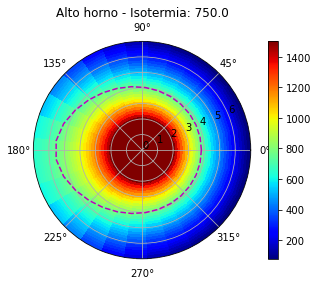

In [8]:
genInstancesPeligrosas(ri=2, re=7, m=30, n=30, iso=750.0, ninst=1, ti=1500.0, te=50.0, 
                       file='./entradas/entrada1.txt', 
                        internalNoise=0.1, externalNoise=0.1, multDeformacion=1500)
generarGraficos(file_in='./entradas/entrada1.txt', file_out='./salidas/salida1.txt', method='1')

In [117]:
genInstancesNormales(ri=0.5, re=0.54, m=60, n=60, iso=0.0, ninst=2, ti=-2.0, te=30.0, 
                 file="./entradas/entradaNE.txt", internalNoise=0.1, externalNoise=0.1)
correr(exe='../src/make/tp1', file_in='./entradas/entradaNE.txt',
          file_out='./salidas/salidaSNE.txt', method='1')
correr(exe='../src/make/tp1NumericErrors', file_in='./entradas/entradaNE.txt',
          file_out='./salidas/salidaNE.txt', method='1')

tempsNE, isoNE = getIsotherm(file_in= './entradas/entradaNE.txt', file_out='./salidas/salidaNE.txt', instancias = [0])
tempsSNE, isoSNE = getIsotherm(file_in= './entradas/entradaNE.txt', file_out='./salidas/salidaSNE.txt', instancias = [0])

print(tempsSNE - tempsNE)

[[[ 0.  0.  0. ...  0.  0.  0.]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [ 0.  0.  0. ...  0.  0.  0.]]]


In [118]:
def getIsothermBoundary(file_in= './entradas/entradaAntesRefinamiento.txt', 
                        file_out='./salidas/salidaAntesRefinamiento.txt', 
                        new_file_in='./entradas/entradaRefinamiento.txt',
                        new_m=30, instancias = [0]):
    
    f = open(file_in,'r',encoding = 'utf-8')
    lines = f.readlines()
    params = num.matrix(lines[0])
    ri = params[0,0]
    re = params[0,1]
    m = int(params[0,2]-1)
    n = int(params[0,3])
    iso = params[0,4]
    ninst = int(params[0,5])
    f.close()
    delta_r = (re - ri)/m
        
    temps_sinParedes = num.loadtxt(file_out).reshape(( m-1, n))
    

    t = num.matrix(lines[1])
    temps = num.vstack((t[0,0:n], temps_sinParedes, t[0,n:2*n]))

    differences = num.abs(temps - iso)
    results = num.empty((n,2))

    for i in range(0, n):
        column = temps[:,i]
        diffcolumn = differences[:,i]
        closest = diffcolumn.argmin()
        border = True

        if column[closest]<iso:
            if closest > 0:
                prev = closest - 1
                pos = closest
            else:
                prev=closest
                pos=closest
        else:
            if closest < m:
                prev = closest
                pos = closest + 1
            else:
                prev=closest
                pos=closest

        results[i,0] = prev
        results[i,1] = pos

    innerIndex = int(results[:,0].min())
    outerIndex = int(results[:,1].max())
    newRi = ri+innerIndex*delta_r
    newRe = ri+outerIndex*delta_r
    internalTemps = num.ravel(temps[innerIndex,:].flatten())
    externalTemps = num.ravel(temps[outerIndex,:].flatten())
    
    f = open(new_file_in,'w',encoding = 'utf-8')
    f.write("{0:.1f} {1:.1f} {2:} {3:} {4:.1f} {5:}\n".format(newRi, newRe, new_m+1, n, iso, ninst))
    f.write(' '.join(["{:.2f}".format(elem) for elem in internalTemps]))
    f.write(' ')
    f.write(' '.join(["{:.2f}".format(elem) for elem in externalTemps]))
    f.write('\n')
    f.close()
    
    return temps, results


In [ ]:
def correrConRefinamiento(exe='../src/make/tp1', file_in='./entradas/entradaAntesRefinamiento.txt',
                          file_out='./salidas/salidaAntesRefinamiento.txt', method='1',
                          new_m=30, cantRef=3):
    
    correr(exe='../src/make/tp1', file_in='./entradas/entradaAntesRefinamiento.txt',
              file_out='./salidas/salidaRefinamiento.txt', method='1')
    
    for ref in range(0, cantRef):
        
    
    tempsAR, isoAR = getIsotherm(file_in='./entradas/entradaAntesRefinamiento.txt',
                                  file_out='./salidas/salidaAntesRefinamiento.txt',  
                                  instancias = [0])
    

In [100]:
genInstancesNormales(ri=4.0, re=7.0, m=30, n=30, iso=750.0, ninst=1, ti=1500.0, te=50.0, file="./entradas/entradaAntesRefinamiento.txt", 
                           internalNoise=0.1, externalNoise=0.1)

correr(exe='../src/make/tp1', file_in='./entradas/entradaAntesRefinamiento.txt',
          file_out='./salidas/salidaAntesRefinamiento.txt', method='1')

tempsAR, isoAR = getIsotherm(file_in='./entradas/entradaAntesRefinamiento.txt',
                              file_out='./salidas/salidaAntesRefinamiento.txt',  
                              instancias = [0])

temps, bounds = getIsothermBoundary(file_in='./entradas/entradaAntesRefinamiento.txt',
                                    file_out='./salidas/salidaAntesRefinamiento.txt', 
                                    new_file_in='./entradas/entradaRefinamiento.txt',
                                    new_m=30, instancias = [0])

correr(exe='../src/make/tp1', file_in='./entradas/entradaRefinamiento.txt',
          file_out='./salidas/salidaRefinamiento.txt', method='1')

tempsRef, isoRef = getIsotherm(file_in='./entradas/entradaRefinamiento.txt',
                               file_out='./salidas/salidaRefinamiento.txt' ,
                               instancias = [0])





[[0.00021421 0.00022319 0.00021743 0.00022822 0.00021296 0.00022572
  0.00022125 0.00021087 0.00022182 0.00021974 0.00022075 0.0002257
  0.00022029 0.00021483 0.00022607 0.00021718 0.00022052 0.00022295
  0.00021583 0.00022739 0.00021702 0.00021824 0.00022163 0.00022737
  0.00022225 0.00021981 0.00021769 0.00022276 0.00022448 0.00022556]]
[[5.34081683 5.34078747 5.34076685 5.34083746 5.34087871 5.34087871
  5.34085962 5.34085809 5.34075495 5.3407467  5.34078747 5.34077558
  5.34073593 5.3407137  5.34077558 5.34085809 5.34085962 5.34085962
  5.34083746 5.34085809 5.34081683 5.34081683 5.34081683 5.34083746
  5.34073593 5.34073593 5.34075495 5.34083746 5.34085809 5.34086634]]
[[[1499.89   1500.11   1499.87   1500.02   1500.     1500.09   1500.05
   1500.01   1500.     1500.     1500.02   1499.91   1499.92   1499.9
   1499.96   1499.94   1500.01   1500.05   1499.91   1500.08   1499.94
   1500.03   1499.87   1500.09   1499.97   1499.95   1499.99   1500.07
   1500.09   1499.8   ]
  [1435.75

In [ ]:
def correrConRefinamiento(exe='../src/make/tp1', file_in='./entradas/entradaAntesRefinamiento.txt',
          file_out='./salidas/salidaAntesRefinamiento.txt', method='1', new_m, instancias=[0])

correr(exe='../src/make/tp1', file_in='./entradas/entradaAntesRefinamiento.txt',
          file_out='./salidas/salidaAntesRefinamiento.txt', method='1')

tempsAR, isoAR = getIsotherm(file_in='./entradas/entradaAntesRefinamiento.txt',
                              file_out='./salidas/salidaAntesRefinamiento.txt',  
                              instancias = [0])

temps, bounds = getIsothermBoundary(file_in='./entradas/entradaAntesRefinamiento.txt',
                                    file_out='./salidas/salidaAntesRefinamiento.txt', 
                                    new_file_in='./entradas/entradaRefinamiento.txt',
                                    new_m=30, instancias = [0])

correr(exe='../src/make/tp1', file_in='./entradas/entradaRefinamiento.txt',
          file_out='./salidas/salidaRefinamiento.txt', method='1')

tempsRef, isoRef = getIsotherm(file_in='./entradas/entradaRefinamiento.txt',
                               file_out='./salidas/salidaRefinamiento.txt' ,
                               instancias = [0])

<ipython-input-26-4c4d0ed3ef4c>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  grafico = ax.pcolor(thetar, r, z, cmap='jet')


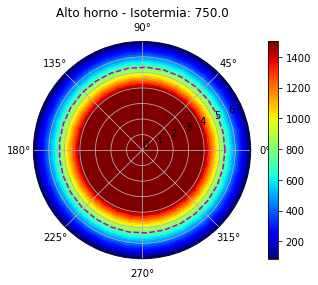

<ipython-input-26-4c4d0ed3ef4c>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  grafico = ax.pcolor(thetar, r, z, cmap='jet')


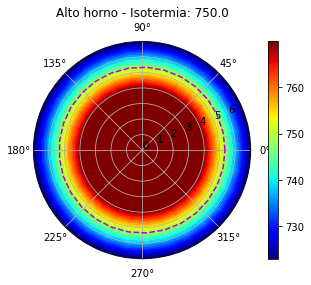

In [103]:
graficar(tempsAR[0], isoAR[0], min_r=4, max_r=7, iso= 750.0)
graficar(tempsRef[0], isoRef[0], min_r=4, max_r=7, iso= 750.0)

### Generacion de casos para evaluar la performance en tiempo de los métodos EG vs LU.

In [56]:
# def generateTestFileForEGvsLU():
#     ninst = 1
#     for n in range(10, 50):
#         for m in range(10, 50):
#             archivo='./testEGvsLU/input/file_n' + str(n) + '_m' + str(m) + '_ninst' + str(ninst) + '.in'
#             genInstancesNormales(ri=4, re=6, m=m, n=n, iso=500, ninst=ninst, ti=1500.0, te=50.0, externalNoise=5.0, file=archivo )

def generateTestFileForEGvsLU(directory, min_n = 10, max_n = 50, min_m = 10, max_m = 50, min_ninst = 1, max_ninst = 1):
    if not os.path.exists(directory):
        os.mkdir(directory)

    for n in range(min_n, max_n+1):
        for m in range(min_m, max_m+1):
            for ninst in range(min_ninst, max_ninst+1):
                archivo= directory + 'file_n' + str(n) + '_m' + str(m) + '_ninst' + str(ninst) + '.in'
                genInstancesNormales(ri=4, re=6, m=m, n=n, iso=500, ninst=ninst, ti=1500.0, te=50.0, externalNoise=5.0, file=archivo )

In [50]:
# generateTestFileForEGvsLU('./testEGvsLU/input/')
# test 2
generateTestFileForEGvsLU('./testEGvsLU/input2/', min_n=16, max_n=16, min_m=8, max_m=8, min_ninst=1, max_ninst=500)
# test 3
generateTestFileForEGvsLU('./testEGvsLU/input3/', min_n=16, max_n=16, min_m=16, max_m=16, min_ninst=1, max_ninst=500)
# test 4
generateTestFileForEGvsLU('./testEGvsLU/input4/', min_n=32, max_n=32, min_m=16, max_m=16, min_ninst=1, max_ninst=200)
# test 5
generateTestFileForEGvsLU('./testEGvsLU/input5/', min_n=32, max_n=32, min_m=32, max_m=32, min_ninst=1, max_ninst=200)

### Benchmarks

In [83]:
import subprocess as sp
import os
import json
from datetime import datetime

now = datetime.now()
currentTime = now.strftime("%Y%m%d_%H%M%S")

pathToExe = "../../build/Release/BenchmarkEGvsLU.exe"
repeat = 10

inputFilesDir = './testEGvsLU/input/'
results = []

for filename in os.listdir(inputFilesDir):
    input_file = os.path.join(inputFilesDir, filename)
    if os.path.isfile(input_file) and input_file.endswith(".in"):
        process = sp.Popen([pathToExe, input_file, str(repeat)], stdout=sp.PIPE)
        (output, err) = process.communicate()
        exitCode = process.wait()
        resultStr = output.decode('utf-8')
        results.append(json.loads(resultStr))

outputFilename = './testEGvsLU/results_{:}.json'.format(currentTime)
with open(outputFilename,'w', encoding='utf-8') as outputFile:
    outputFile.write(json.dumps(results, indent=4))


